# Alice's Rose

## Dependencies

The `import` statement is special... it imports programmer's wisdom!
The common usage is to acquire access to python packages.

In [3]:
import sympy
import math

## A Romantic Introduction to Matematical Optimization and to Python

Note: this story was originally told in the book [Optimization](https://press.princeton.edu/books/hardcover/9780691102870/optimization) and the protagonist there is called Samantha, but we stick to the alphabetical order...

As the story goes, Alice receives a beautiful rose. She has nothing but a lemonade glass to hold the rose and becomes very distressed when the ensemble falls down. 

Adding a bit of water helps! Not only that helps the rose, but it also helps the stability: glass, with some water, and rose stands!

Alice thinks: if a bit of water helps, the let us fill the glass! 

However, it tilts and falls, as in the beginning, just much more wet. 

Alice has a problem to solve: what is the _optimal_ level of water for her rose on a lemonade glass?

She learns from [Archimedes]( https://en.wikipedia.org/wiki/Archimedes) how to compute the _center of gravity_ of the glass with water, which has height
$h = \frac{m_w}{m_w+m_g} h_w + \frac{m_g}{m_w+m_g} h_g$ with:

* $m_w$ the mass of water 
* $m_g$ the mass of glass
* $h_w$ the height of the center of gravity of the water in the glass
* $h_g$ the height of the center of gravity of the glass without water 

Since Alice's glass is $20$ cm tall, $4$ cm wide and weighs $100$ gram, Alice may fill the glass with water up to height $x$ cm, provided that $0 \leq x \leq 20$ since the water must fit in the glass.

The volume of water is $\pi r^2 x$ with $r$ the radius of the base, i.e. $r=2$. 
The volume is therefore $4\pi x$ cubic centimetres. 

Since the density of water can be [taken](https://en.wikipedia.org/wiki/Gram_per_cubic_centimetre) as being $1$ gram per cubic centimeter we have:

* $m_w = 4\pi x$
* $m_g = 100$
* $h_w = \frac{x}{2}$
* $h_g = \frac{20}{2} = 10$ 

And from here we finally obtain the following formula for the height of the center of gravity of the glass with water:

$$
h = \frac{4\pi x}{4\pi x + 100} \frac{x}{2} + \frac{100}{4\pi x + 100} 10 = \frac{4\pi x^2 + 2000}{8\pi x + 200}
$$

Alice's problem is therefore:

$$
\begin{array}{rl}
\min    & \frac{4\pi x^2 + 2000}{8\pi x + 200}  \\
s.t.    & x \geq 0   \\
        & x \leq 20  \\
\end{array}
$$

## Analytical solution

Alice learns from [Fermat]( https://en.wikipedia.org/wiki/Pierre_de_Fermat) that for a function to reach its highest and lowest points inside its domain the derivative must vanish. 

This is a good moment to play with symbolic mathematics in python, we will use [sympy](https://www.sympy.org/en/index.html).

### With $\pi$ as a number

In [4]:
# x is a symbol and pi is a number
x = sympy.Symbol('x')
pi = math.pi

# h is a function of x, and hprime its derivative 
h = (4*pi*x**2 + 2000)/(8*pi*x+200)
hprime = sympy.diff(h, x)

# sol is(are) the value(s) of x that solve hprime(x) == 0
sol = sympy.solveset(hprime, x)
sol

{-22.8735335189926, -7.95774715459477, 6.95803920980307}

Above we see that the equation $h^\prime(x) = 0$ has two solutions: one negative and one positive. 
Obviously, only the positive may be feasible for Alice. 
And, since its value is between $0$ and $20$, it is indeed feasible. 

You may recall that the sign of the second derivative tells you whether the root of the first derivative is a *maximum*, a *minimum* or a *saddle point*.

In [5]:
opt = max(sol)
sympy.diff(hprime, x).subs(x,opt).evalf()

0.0670430626699561

Since $h^{\prime\prime}(\text{opt}) > 0$ it is indeed a (local) **minimum**.

### With $\pi$ as a symbol

In [6]:
# now pi is a symbol, just like x
pi = sympy.Symbol('pi')

# we redefine h using the same right-hand-side code as before, 
# but now with x and pi as symbols
h = (4*pi*x**2 + 2000)/(8*pi*x + 200)

# to have the drivative on the symbol pi we need it from the new version of h
hprime = sympy.diff(h, x)

solution = sympy.solveset(sympy.diff(h, x), x )
solution

{(-5*sqrt(5)*sqrt(4*pi + 5) - 25)/pi, (5*sqrt(5)*sqrt(4*pi + 5) - 25)/pi}

### From a symbolic $\pi$ to a numeric $\pi$

In [7]:
s = max(solution.subs(pi, math.pi).evalf())
print(s)

6.95803920980307


### A picture says more than thousand words

In [8]:
import matplotlib.pyplot as plt
import numpy as np
    
def plot_alice(h, s, start, stop, width=18, height=8):

    plt.rcParams["figure.figsize"] = (18,8)

    x = sympy.Symbol('x')
    f = sympy.lambdify(x, h.subs( pi, math.pi))

    x = np.linspace(start=start,stop=stop,num=100) 
    y = f(x)

    plt.plot(x,y,label='$'+sympy.latex(h)+'$',linewidth=3)
    plt.plot(s,f(s), 'ro', label='optimum', markersize=12)

    plt.legend()
    plt.show() 

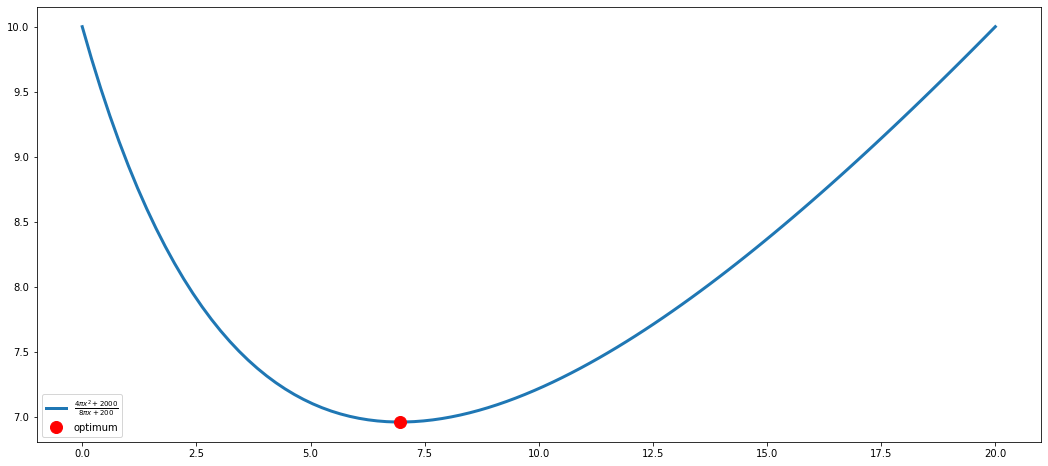

In [9]:
plot_alice( h, s, 0, 20 )

## What if we only care about the numerical solution?

### Introducing `pyomo`

This is the moment to meet:
 * mathematical models expressed in `python`, using `pyomo`,
 * powerful numerical optimization algorithms and how to use them. 

We will see that `pyomo` completely separates modeling from solving, which allows us to switch solver without recoding! 

### Notebook dependencies requiring installation on `colab`

Note that [this notebook](https://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/01.02-Running-Pyomo-on-Google-Colab.ipynb) explains how to run `Pyomo` on Google Colab. 
For a complete overview please check the [cookbook](https://jckantor.github.io/ND-Pyomo-Cookbook/).

In [10]:
import shutil
if not shutil.which('pyomo'):
    !pip install -q pyomo
    assert(shutil.which('pyomo'))

In [11]:
import pyomo.environ as pyo

alice = pyo.ConcreteModel('Alice')
alice.h = pyo.Var(bounds=(0,20))

@alice.Objective(sense=pyo.minimize)
def cog(m):
    return (4*math.pi*alice.h**2 + 2000)/(8*math.pi*alice.h + 200)

alice.pprint()

1 Var Declarations
    h : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :    20 : False :  True :  Reals

1 Objective Declarations
    cog : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : (12.566370614359172*h**2 + 2000)/(25.132741228718345*h + 200)

2 Declarations: h cog


We will use `ipopt`. We refer again to [this notebook](https://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/01.02-Running-Pyomo-on-Google-Colab.ipynb) explains how to run `Pyomo` **and how to install solvers** on Google Colab. For a complete overview please check the [cookbook](https://jckantor.github.io/ND-Pyomo-Cookbook/).

In [12]:
import sys
if 'google.colab' in sys.modules:
    !wget -N -q 'https://ampl.com/dl/open/ipopt/ipopt-linux64.zip'
    !unzip -o -q ipopt-linux64

In [13]:
results = pyo.SolverFactory('ipopt').solve(alice)
print(results.solver.status, results.solver.termination_condition )
alice.display()

ok optimal
Model Alice

  Variables:
    h : Size=1, Index=None
        Key  : Lower : Value            : Upper : Fixed : Stale : Domain
        None :     0 : 6.95803921230998 :    20 : False : False :  Reals

  Objectives:
    cog : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 6.95803920980307

  Constraints:
    None


## Conclusion

This notebook shows how to solve Alice's problem: finding the most stable amount of water in a vase. 

The notebook shows how to solve the problem analytically with `sympy`, how to use `matplotlib` to visualize the function and the optimum. And how to model Alice's problem on `pyomo` and solve it with `ipopt` both at [neos](https://neos-server.org/neos/solvers/index.html) and "locally" at your own Colab session.


## Last remarks

This notebook deferred installation of the packages needed to the moment that we needed them. This was deliberate, but subsequent notebooks will normally list all dependencies on their top part, which we often call the _preamble_. Furthermore, the `colab' dependencies will be streamlined in future notebooks. 